### Pre-process the Data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
import random

In [2]:
def random_brightness(img, factor):
    # assume input is color image
    # convert Red, Green, Blue to Hue, Saturation, Value
    # factor describes the range of brightness scaling: (1 - factor, 1 + factor)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    bright_factor = random.uniform(1. - factor, 1. + factor)
    #print("brightness", bright_factor)
    img_hsv = np.array(img_hsv, np.float)
    img_hsv[:,:,2] = np.minimum(255, img_hsv[:,:,2] * bright_factor)
    img_hsv = np.array(img_hsv, dtype = np.uint8)
    img_new = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    return img_new

In [3]:
def xy_translation(img, steer, dfactor):
    # assume input is color image
    # dfactor is the fraction of total pixels as translation range
    nrow, ncol, nch = img.shape
    tX = dfactor * ncol * random.uniform(-1., 1.)
    tY = dfactor * 0.3 * nrow * random.uniform(-1., 1.) # give vertical translation less freedom
    #print("right shift =", tX)
    #print("down shift =", tY)
    Mtrans = np.float32([[1,0,tX], [0,1,tY]])
    img_new = cv2.warpAffine(img, Mtrans,(ncol, nrow))
    steer_new = steer + tX * .004
    return img_new, steer_new

In [4]:
def crop_resize(img, new_row, new_col):
    nrow, ncol, nch = img.shape
    # crop out img[y1:y2, x1:x2]
    # y1 = 0.3 * nrow: leave out the top 0.3 of image
    # y2 = nrow - 25: leave out the bottom 25 rows
    img_new = img[int(nrow * 0.3) : nrow - 25, 0 : ncol]
    img_new = cv2.resize(img_new,(new_col,new_row), interpolation=cv2.INTER_AREA)
    return img_new

In [5]:
data_dir = "./data/"
driving_log = pd.read_csv(data_dir + "driving_log.csv")

In [6]:
n_entries, n_feats = driving_log.shape

In [7]:
driving_log.head(3)

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011


In [8]:
driving_log.tail(3)

,center,left,right,steering,throttle,brake,speed
8033,IMG/center_2016_12_01_13_46_38_846.jpg,IMG/left_2016_12_01_13_46_38_846.jpg,IMG/right_2016_12_01_13_46_38_846.jpg,0.0,0.0,0.0,1.388364
8034,IMG/center_2016_12_01_13_46_38_922.jpg,IMG/left_2016_12_01_13_46_38_922.jpg,IMG/right_2016_12_01_13_46_38_922.jpg,0.0,0.0,0.0,1.377208
8035,IMG/center_2016_12_01_13_46_38_947.jpg,IMG/left_2016_12_01_13_46_38_947.jpg,IMG/right_2016_12_01_13_46_38_947.jpg,0.0,0.0,0.0,1.374433


In [9]:
n_entries

8036

In [10]:
steer_correct = {'left': -0.25, 'center' : 0., 'right' : 0.25}

In [11]:
def preprocess_train(entry, cam_pos):
    filename = entry[cam_pos].strip()
    steering = float(entry['steering']) + float(steer_correct[cam_pos])
    img = cv2.imread(data_dir + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    br_img = random_brightness(img, 0.5)
    tr_img, steer_new = xy_translation(br_img, steering, 0.2)
    cr_img = crop_resize(tr_img, 66, 200)
    flip_ornot = np.random.randint(2)
    if flip_ornot == 1:
        image = cv2.flip(cr_img, 1)    #1 means flip around y-axis
        steer_new *= -1
    else:
        image = cr_img
    image = np.array(image)
    return image, steer_new

In [12]:
def preprocess_valid(entry):
    filename = entry['center'].strip()
    #steering = float(entry['steering'])
    img = cv2.imread(data_dir + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = np.array(img)
    return image

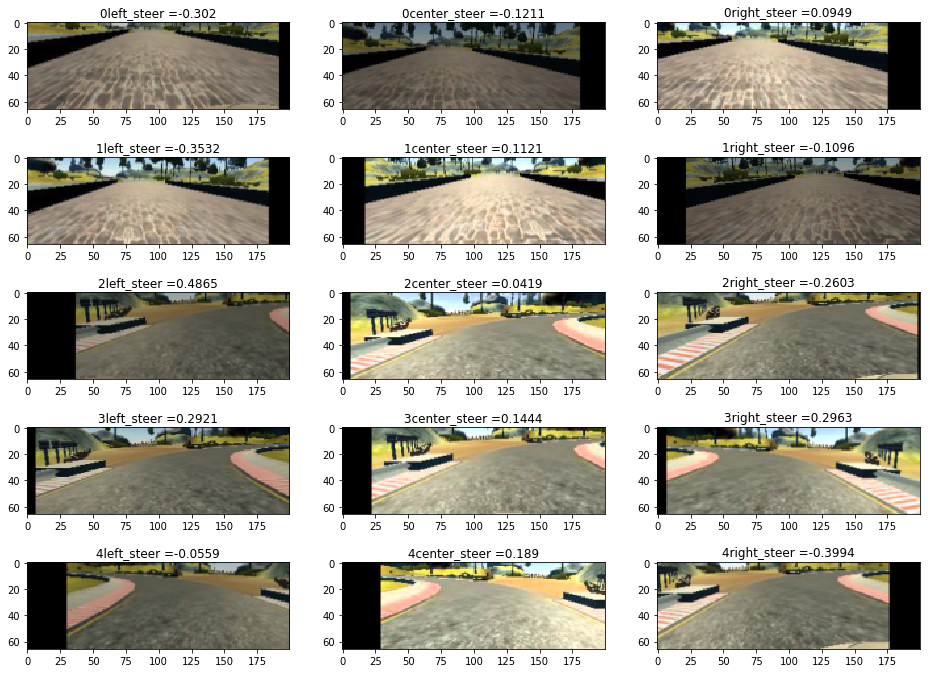

In [13]:
fig = plt.figure(figsize = (16, 12))
for i in range(5):
    j = 0
    for p in ['left', 'center', 'right']:
        image, steering = preprocess_train(driving_log.loc[i,:], p)
        ax = fig.add_subplot(5, 3, i*3 + j + 1)
        ax.imshow(image)
        #ax.set_title('steer =' + str(np.round(steering, 4)))
        ax.set_title(str(i) + p + '_steer =' + str(np.round(steering, 4)))
        j += 1
    

In [ ]:
path = './data/IMG/'
#filenames = ['center_2016_12_01_13_33_45_217.jpg', 'center_2016_12_01_13_33_54_272.jpg', 'center_2016_12_01_13_33_59_244.jpg']
#filenames = ['center_2016_12_01_13_33_45_217.jpg', 'center_2016_12_01_13_33_54_272.jpg']
filenames = ['_2016_12_01_13_33_45_217.jpg', '_2016_12_01_13_33_54_272.jpg', '_2016_12_01_13_33_59_244.jpg']
steer = [0.406227, -0.2306556, 0]
#steer = [0.406227, -0.406227, -0.2306556, 0.2306556]
#steer = [0.406227, -0.2306556]
camera_pos = ['left', 'center', 'right']
steer_correct = [-0.25, 0., 0.25]
images = []
label = []
for i in range(3):
    for j in range(3):
        file_name = camera_pos[j] + filenames[i]
        file_path = path + file_name
        this_steer = steer[i] + steer_correct[j]
        img = cv2.imread(file_path) #cv2 read in images as BGR (not RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #images.append(img)
        #label.append(this_steer)
        
        #steer_new = this_steer
        fl_img = cv2.flip(img, 1)
        br_img = random_brightness(fl_img, 0.7)
        tr_img, steer_new = xy_translation(br_img, this_steer, 0.2)
        cr_img = crop_resize(tr_img, 66, 200)
        #print(img.shape)
    
        fig, ax = plt.subplots(ncols = 2, figsize = (16,9))
        ax[0].set_title('steer =' + str(np.round(this_steer, 4)))
        ax[0].imshow(img)
        #ax[1].imshow(fl_img)
        #ax[1].imshow(br_img)
        #ax[1].imshow(tr_img)
        ax[1].imshow(cr_img)
        ax[1].set_title('steer =' + str(np.round(steer_new, 4)))
    
        
        images.append(cr_img)    #1 means flip around y-axis
        label.append(steer_new)

In [ ]:
# convert to numpy arrays for Keras
X_train = np.array(images)
y_train = np.array(label)
len(images), len(label), X_train.shape, y_train.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D


In [ ]:
model = Sequential()
model.add(Lambda(lambda x : x/255. - 0.5, input_shape = (66, 200, 3)))
# 3 @ 1x1 filter to choose color space automatically
model.add(Convolution2D(3, 1, 1, init = 'he_normal', activation = 'elu', border_mode = 'valid', name = 'conv0'))
#
model.add(Convolution2D(24, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv1'))
model.add(Convolution2D(36, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv2'))
model.add(Convolution2D(48, 5, 5, init = 'he_normal', subsample = (2, 2), border_mode = 'valid', activation = 'elu', name = 'conv3'))
model.add(Convolution2D(64, 3, 3, init = 'he_normal', subsample = (1, 1), border_mode = 'valid', activation = 'elu', name = 'conv4'))
model.add(Convolution2D(64, 3, 3, init = 'he_normal', subsample = (1, 1), border_mode = 'valid', activation = 'elu', name = 'conv5'))
model.add(Flatten())
model.add(Dense(100, init = 'he_normal', activation = 'elu', name = 'full1'))
model.add(Dense(50, init = 'he_normal', activation = 'elu', name = 'full2'))
model.add(Dense(10, init = 'he_normal', activation = 'elu', name = 'full3'))
model.add(Dense(1, init = 'he_normal', name = 'full4'))

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, nb_epoch = 50) #, validation_split = 0.2, shuffle = True
y_pred = model.predict(X_train)
print(y_pred)

model.save('model.h5')